In [38]:
import numpy as np
import sys
sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
import analog
import matplotlib.pyplot as plt

In [39]:
import platform 
if platform.system() == 'Linux':
    folder = '/home/lucas/Documents/Log_Analysis/Logs/Snow Orange (Battery 9) z0=1'
if platform.system() == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/Snow Orange (Battery 9) z0=1'
log_file = analog.pathfromQGC(folder,index=195)
info = analog.logextract(log_file,'battery_status')

In [40]:
u = info['battery_current']
u = np.reshape(u,(len(u),1))
print(np.shape(u))
t = info['time_bs']
y = info['battery_voltage']/4
y = np.reshape(y,(len(y),1))
print(np.shape(y))

(30348, 1)
(30348, 1)


In [47]:
u=u[t>60]
y=y[t>60]
t=t[t>60]

In [68]:
N = 14500
twoi = 14500 # i>n, the system order
i = int(twoi/2)
print(len(u))
print(i)

29248
7250


<IPython.core.display.Javascript object>


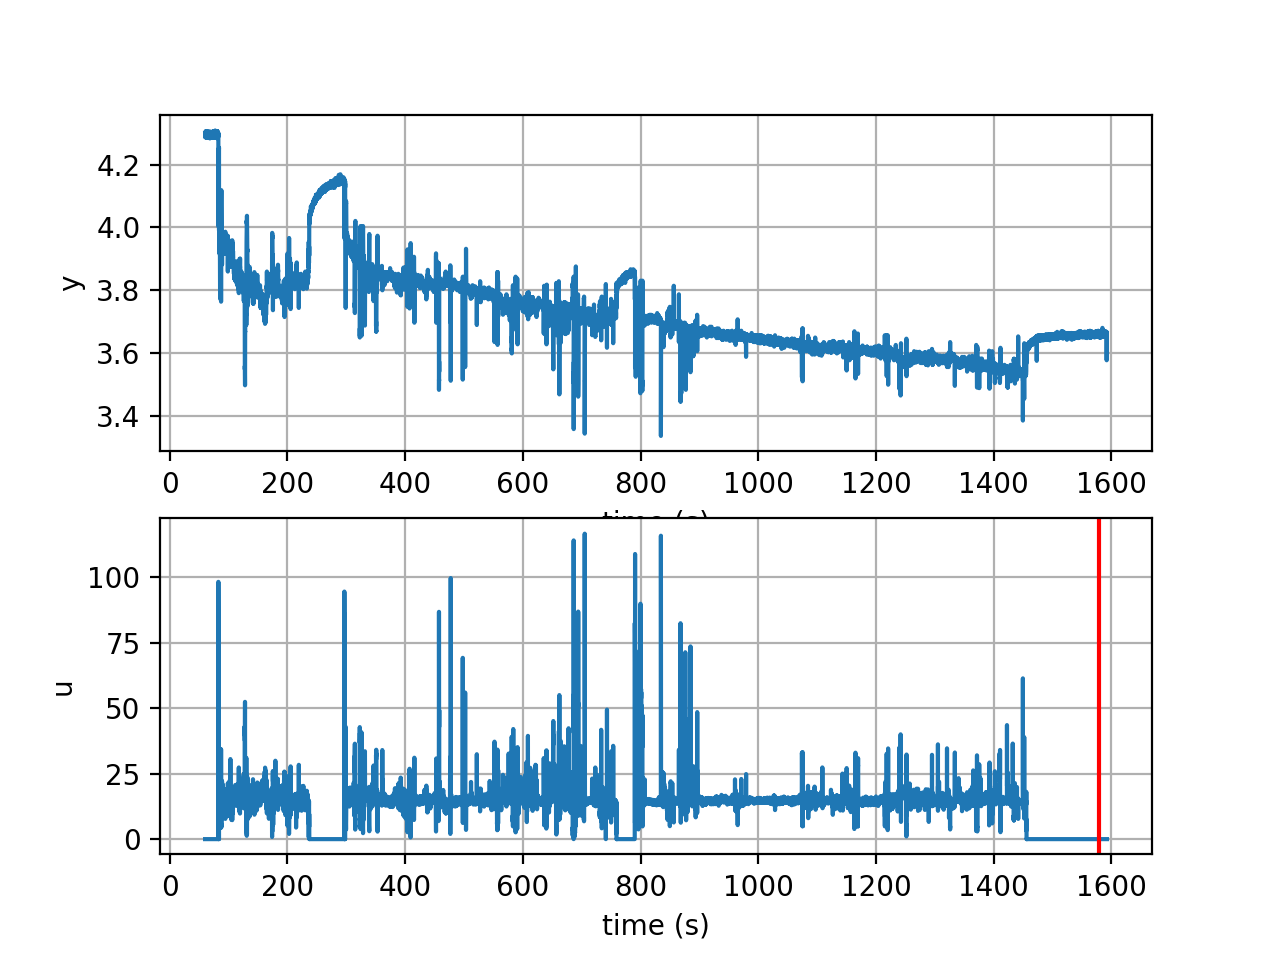

In [69]:
plt.figure()
plt.subplot(211)
plt.plot(t,y)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('y')

plt.subplot(212)
plt.plot(t,u)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('u')
plt.axvline(t[twoi+N-1],color='r')

In [ ]:
# block Hankel control matrix

U = u[:twoi]

for n in range(N-1):
    #print(f'n={n}')
    U = np.hstack([U,u[n:twoi+n]])
    #print(U)

In [7]:
print(f'U is {np.shape(U)}')

U is (300, 1000)


In [8]:
# block Hankel observation matrix

Y = y[:twoi]

for n in range(N-1):
    #print(f'n={n}')
    Y = np.hstack([Y,y[n:twoi+n]])
    #print(U)

In [9]:
print(f'Y is {np.shape(Y)}')

Y is (300, 1000)


In [10]:
Up = U[0:i,:] # past inputs
Uf = U[i:,:] # future inputs 
Yp = Y[0:i,:] # past outputs
Yf = Y[i:,:] # future outputs

In [18]:
print(f'Up is {np.shape(Up)}')
print(f'Yp is {np.shape(Yp)}')

Wp = np.vstack([Up,Yp])
print(f'Uf is {np.shape(Uf)}')
print(f'pinv(Uf*Uf.T) is {np.shape(np.linalg.pinv(Uf@Uf.T))}')
PiUf = Uf.T@np.linalg.pinv(Uf@Uf.T)@Uf
print(f'Id is {np.shape(np.identity(np.shape(Uf)[0]))}')
print(f'PiUf is {np.shape(PiUf)}')
PiUfortho = np.identity(np.shape(PiUf)[0]) - PiUf

Up is (150, 1000)
Yp is (150, 1000)
Uf is (150, 1000)
pinv(Uf*Uf.T) is (150, 150)
Id is (150, 150)
PiUf is (1000, 1000)


In [19]:
print(f'Yf is {np.shape(Yf)}')
print(f'Wp is {np.shape(Wp)}') # should be 2i long
print(f'PiUfortho is {np.shape(PiUfortho)}')
ksi = (Yf@PiUfortho)@np.linalg.pinv((Wp@PiUfortho))@Wp 
u,s,vh = np.linalg.svd(ksi,compute_uv=True)

Yf is (150, 1000)
Wp is (300, 1000)
PiUfortho is (1000, 1000)


In [33]:
print(f'ksi is {np.shape(ksi)}')
print(f'u is {np.shape(u)}')
print(f's is {np.shape(s)}')
print(f'vh is {np.shape(vh)}')
Sigma = np.hstack([np.diag(s),np.zeros((i,N-i))])
print(f'maximal error is {np.max(ksi-u@Sigma@vh)}')

ksi is (150, 1000)
u is (150, 150)
s is (150,)
vh is (1000, 1000)
maximal error is 2.282618538629322e-13


<IPython.core.display.Javascript object>


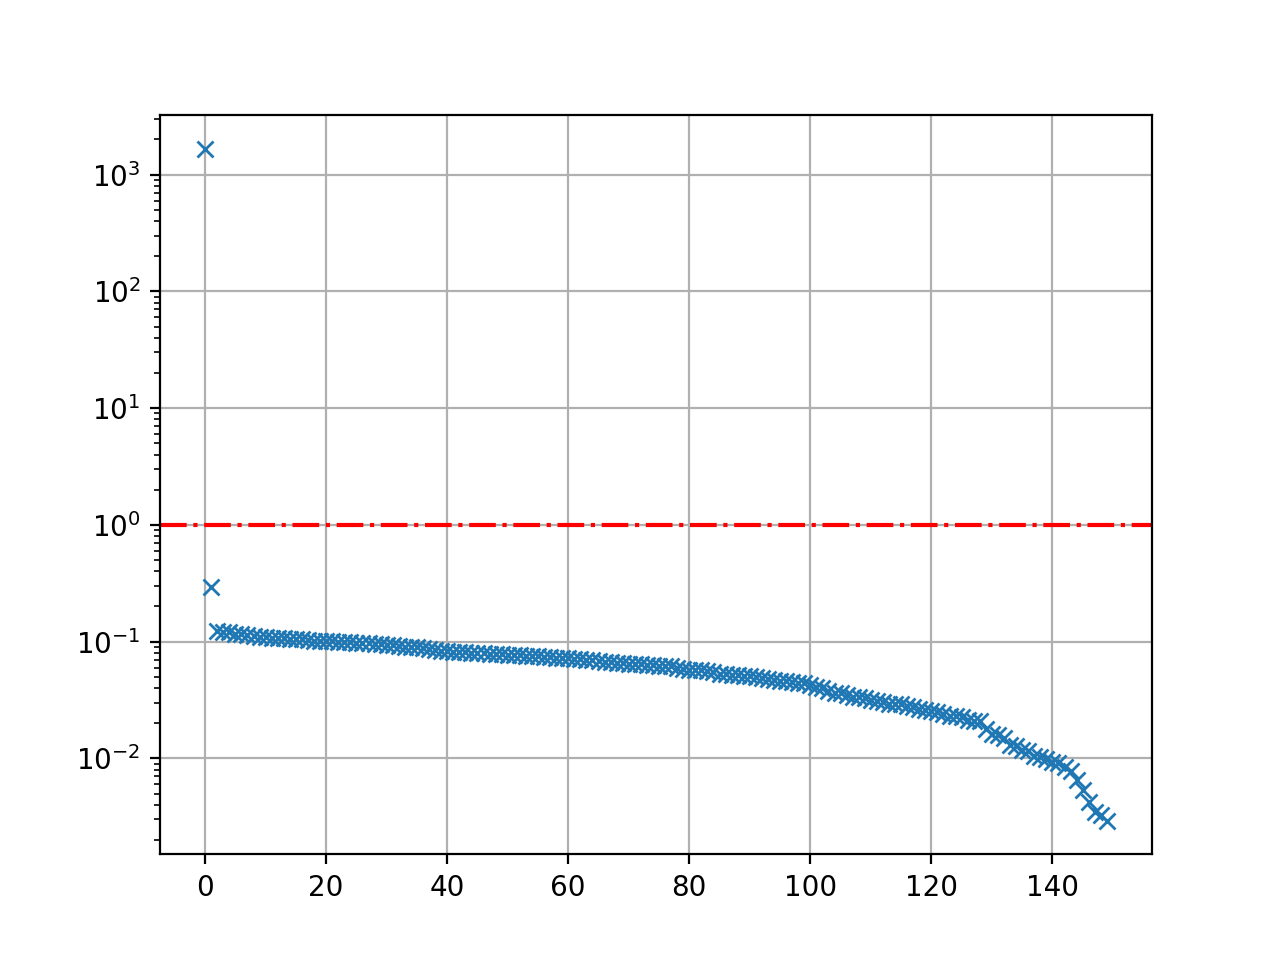

In [13]:
%matplotlib notebook
plt.figure()
plt.axhline(1,color='r',LineStyle='-.')
plt.semilogy(s,'x')
plt.grid()

In [35]:
print(f'Order to be retained is {np.shape(s[s>1])[0]}')
print(s[s>1])

Order to be retained is 1
[1664.08472448]
